<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_55/1613476412.py:9: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep='\s+', names=['head', 'relation', 'tail'])


Total rows: 13821

First 5 rows:
      head      relation        tail
0  olivia0      sisterOf    selina10
1  olivia0      sisterOf  isabella11
2  olivia0      sisterOf     oskar24
3  olivia0      sisterOf       adam9
4  olivia0  secondAuntOf      lena18

Relationship Counts:
relation
grandsonOf                      814
grandmotherOf                   813
grandfatherOf                   813
granddaughterOf                 812
motherOf                        733
fatherOf                        733
sisterOf                        636
daughterOf                      628
greatGrandsonOf                 624
greatGrandmotherOf              617
greatGrandfatherOf              617
greatGranddaughterOf            610
sonOf                           600
brotherOf                       570
auntOf                          556
nephewOf                        514
nieceOf                         496
uncleOf                         454
girlCousinOf                    445
boyCousinOf                   

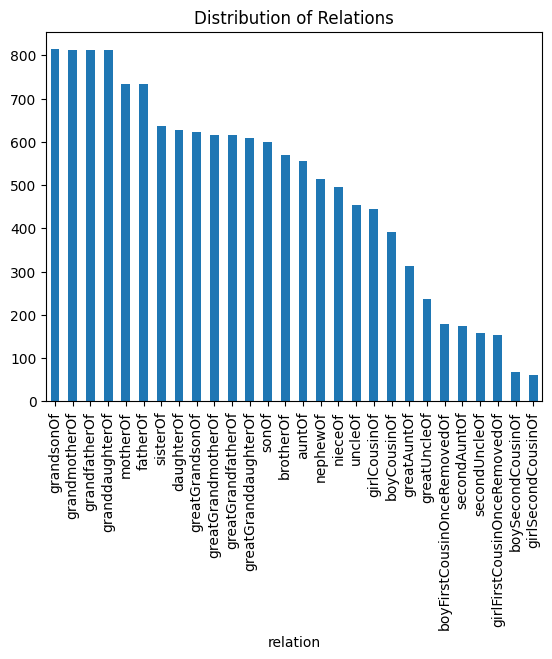

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1. Load the dataset
file_path = '/kaggle/input/train-txt/train.txt'

# The file has no header, so we name the columns manually
df = pd.read_csv(file_path, sep='\s+', names=['head', 'relation', 'tail'])

# 2. Basic Sanity Check
print(f"Total rows: {len(df)}")
print("\nFirst 5 rows:")
print(df.head())

# 3. Task Requirement: "What's the distribution of different relationships?" 
print("\nRelationship Counts:")
print(df['relation'].value_counts())

df['relation'].value_counts().plot(kind='bar', title='Distribution of Relations')
plt.show()

In [3]:
# Create a Directed Graph
G = nx.DiGraph()

# Add edges from the dataframe
# zip() lets us iterate through the 3 columns simultaneously
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    G.add_edge(h, t, relation=r)

# Task Requirement: "How many people are there?" 
print(f"Number of Nodes (People): {G.number_of_nodes()}")
print(f"Number of Edges (Relationships): {G.number_of_edges()}")

# Check if the graph is connected (Can you reach everyone from everyone?)
# Since it's directed, we check "weakly connected" (ignoring direction) to see if it's one big family or islands.
print(f"Is the graph connected? {nx.is_weakly_connected(G)}")
print(f"Number of connected components: {nx.number_weakly_connected_components(G)}")

Number of Nodes (People): 1316
Number of Edges (Relationships): 13821
Is the graph connected? False
Number of connected components: 50



Component Size Distribution:
  Largest family: 27 people
  Smallest family: 26 people
  Median family size: 26 people
  Top 10 family sizes: [27, 27, 27, 27, 27, 27, 27, 27, 27, 27]


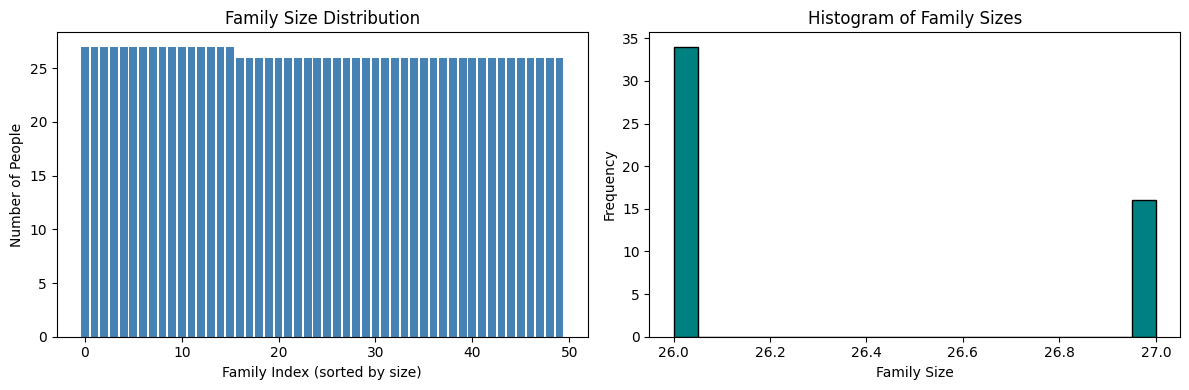

In [22]:
# --- Component Size Distribution ---
component_sizes = sorted([len(c) for c in nx.weakly_connected_components(G)], reverse=True)

print(f"\nComponent Size Distribution:")
print(f"  Largest family: {component_sizes[0]} people")
print(f"  Smallest family: {component_sizes[-1]} people")
print(f"  Median family size: {component_sizes[len(component_sizes)//2]} people")
print(f"  Top 10 family sizes: {component_sizes[:10]}")

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(range(len(component_sizes)), component_sizes, color='steelblue')
plt.xlabel("Family Index (sorted by size)")
plt.ylabel("Number of People")
plt.title("Family Size Distribution")

plt.subplot(1, 2, 2)
plt.hist(component_sizes, bins=20, color='teal', edgecolor='black')
plt.xlabel("Family Size")
plt.ylabel("Frequency")
plt.title("Histogram of Family Sizes")
plt.tight_layout()
plt.show()

In [23]:
# --- KNOWLEDGE GRAPH VALIDATION: Reciprocity Check ---
# If (A, fatherOf, B) exists, does (B, sonOf, A) or (B, daughterOf, A) exist?

reciprocal_map = {
    'fatherOf': ['sonOf', 'daughterOf'],
    'motherOf': ['sonOf', 'daughterOf'],
    'sonOf': ['fatherOf', 'motherOf'],
    'daughterOf': ['fatherOf', 'motherOf'],
    'brotherOf': ['brotherOf', 'sisterOf'],
    'sisterOf': ['brotherOf', 'sisterOf'],
    'grandfatherOf': ['grandsonOf', 'granddaughterOf'],
    'grandmotherOf': ['grandsonOf', 'granddaughterOf'],
    'grandsonOf': ['grandfatherOf', 'grandmotherOf'],
    'granddaughterOf': ['grandfatherOf', 'grandmotherOf'],
    'uncleOf': ['nephewOf', 'nieceOf'],
    'auntOf': ['nephewOf', 'nieceOf'],
    'nephewOf': ['uncleOf', 'auntOf'],
    'nieceOf': ['uncleOf', 'auntOf'],
}

# Build edge lookup for fast checking
edge_set = set(zip(df['head'], df['relation'], df['tail']))

missing_reciprocals = []
checked = 0
for h, r, t in edge_set:
    if r in reciprocal_map:
        checked += 1
        expected_relations = reciprocal_map[r]
        found = any((t, exp_r, h) in edge_set for exp_r in expected_relations)
        if not found:
            missing_reciprocals.append((h, r, t))

print(f"Checked {checked} edges with expected reciprocals")
print(f"Missing reciprocal edges: {len(missing_reciprocals)}")
print(f"Reciprocity Rate: {100 * (1 - len(missing_reciprocals)/checked):.2f}%")

if missing_reciprocals:
    print(f"\nExamples of missing reciprocals:")
    for edge in missing_reciprocals[:10]:
        print(f"  {edge[0]} --{edge[1]}--> {edge[2]} (reverse not found)")

Checked 9172 edges with expected reciprocals
Missing reciprocal edges: 590
Reciprocity Rate: 93.57%

Examples of missing reciprocals:
  lena395 --daughterOf--> jakob403 (reverse not found)
  luis1014 --fatherOf--> leonie1016 (reverse not found)
  paul739 --fatherOf--> jonathan750 (reverse not found)
  valentina115 --daughterOf--> claudia109 (reverse not found)
  emilia1308 --motherOf--> lea1291 (reverse not found)
  lena1265 --motherOf--> leonie1280 (reverse not found)
  magdalena866 --motherOf--> olivia849 (reverse not found)
  leon181 --sonOf--> tobias174 (reverse not found)
  marie894 --motherOf--> noah905 (reverse not found)
  julia1213 --motherOf--> nina1221 (reverse not found)


In [24]:
# --- TRANSITIVITY RULES: Does the KG follow family logic? ---
# Rule: If A fatherOf B AND B fatherOf C, then A grandfatherOf C should exist

transitivity_rules = [
    (['fatherOf', 'motherOf'], ['fatherOf', 'motherOf'], 'grandfatherOf', 'grandmotherOf'),
    (['fatherOf', 'motherOf'], ['sonOf', 'daughterOf'], 'brotherOf', 'sisterOf'),  # siblings
]

# Check Rule 1: Parent of Parent = Grandparent
parent_rels = ['fatherOf', 'motherOf']
grandparent_rels = ['grandfatherOf', 'grandmotherOf']

# Build lookup: who are the children of each person?
children_of = {}
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in parent_rels:
        if h not in children_of:
            children_of[h] = []
        children_of[h].append(t)

# Check transitivity
expected_grandparent_edges = 0
found_grandparent_edges = 0

for grandparent, parents in children_of.items():
    for parent in parents:
        if parent in children_of:
            grandchildren = children_of[parent]
            for grandchild in grandchildren:
                expected_grandparent_edges += 1
                # Check if grandparent -> grandchild edge exists
                for gp_rel in grandparent_rels:
                    if (grandparent, gp_rel, grandchild) in edge_set:
                        found_grandparent_edges += 1
                        break

print(f"Transitivity Check: Grandparent Relationships")
print(f"  Expected grandparent edges (based on parent chains): {expected_grandparent_edges}")
print(f"  Found grandparent edges: {found_grandparent_edges}")
print(f"  Transitivity Completeness: {100*found_grandparent_edges/max(1,expected_grandparent_edges):.2f}%")

Transitivity Check: Grandparent Relationships
  Expected grandparent edges (based on parent chains): 1294
  Found grandparent edges: 1294
  Transitivity Completeness: 100.00%


In [25]:
# --- CLUSTERING COEFFICIENT (Explicitly required by the task) ---
# Convert to undirected for clustering analysis
G_undirected = G.to_undirected()

# Global clustering coefficient
global_clustering = nx.transitivity(G_undirected)
print(f"Global Clustering Coefficient: {global_clustering:.4f}")

# Average local clustering
avg_local_clustering = nx.average_clustering(G_undirected)
print(f"Average Local Clustering Coefficient: {avg_local_clustering:.4f}")

# Compare to a random graph with same nodes/edges
n, m = G.number_of_nodes(), G.number_of_edges()
random_graph = nx.gnm_random_graph(n, m)
random_clustering = nx.transitivity(random_graph)
print(f"\nRandom Graph Clustering (same n, m): {random_clustering:.4f}")
print(f"Family graph is {global_clustering/max(random_clustering, 0.0001):.1f}x more clustered than random")

# Interpretation
print("\n Interpretation:")
if global_clustering > 0.3:
    print("  High clustering: Family members form tight-knit groups (expected for families)")
elif global_clustering > 0.1:
    print("  Moderate clustering: Some family groupings visible")
else:
    print("  Low clustering: Relationships are more spread out")

Global Clustering Coefficient: 0.7696
Average Local Clustering Coefficient: 0.7908

Random Graph Clustering (same n, m): 0.0153
Family graph is 50.2x more clustered than random

📊 Interpretation:
  High clustering: Family members form tight-knit groups (expected for families)


In-Degree Stats (edges pointing TO a person):
  Mean: 10.50
  Max: 23 (node: dominik1036)

Out-Degree Stats (edges FROM a person):
  Mean: 10.50
  Max: 22 (node: oskar133)


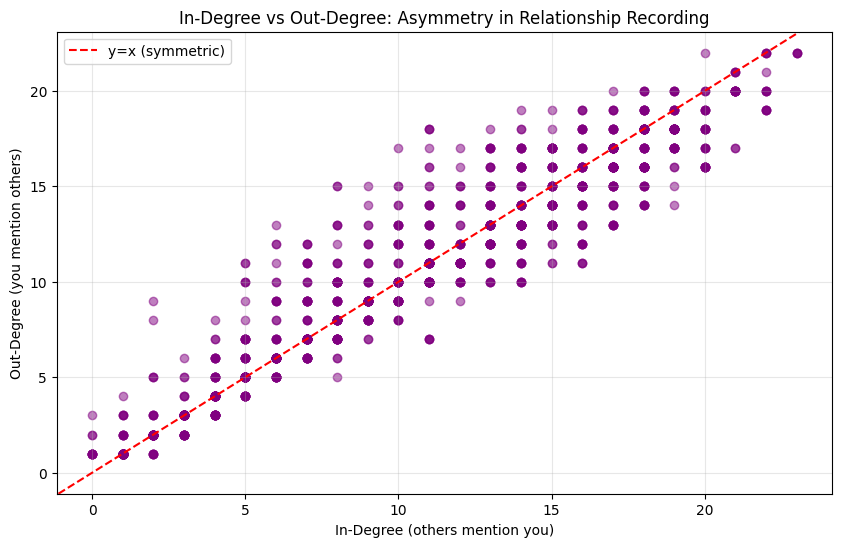


Most 'Outward' nodes (mention others more than being mentioned):
  sophie309: out-in = 7
  konstantin493: out-in = 7
  sarah592: out-in = 7
  charlotte624: out-in = 7
  thomas1214: out-in = 7

Most 'Inward' nodes (mentioned more than they mention):
  natalie811: out-in = -5
  simon1197: out-in = -5
  vanessa1200: out-in = -5
  stefan1192: out-in = -5
  rene112: out-in = -4


In [26]:
# --- DIRECTED GRAPH ANALYSIS: In-Degree vs Out-Degree ---
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

in_deg_values = list(in_degrees.values())
out_deg_values = list(out_degrees.values())

print("In-Degree Stats (edges pointing TO a person):")
print(f"  Mean: {sum(in_deg_values)/len(in_deg_values):.2f}")
print(f"  Max: {max(in_deg_values)} (node: {max(in_degrees, key=in_degrees.get)})")

print("\nOut-Degree Stats (edges FROM a person):")
print(f"  Mean: {sum(out_deg_values)/len(out_deg_values):.2f}")
print(f"  Max: {max(out_deg_values)} (node: {max(out_degrees, key=out_degrees.get)})")

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(in_deg_values, out_deg_values, alpha=0.5, c='purple')
plt.xlabel("In-Degree (others mention you)")
plt.ylabel("Out-Degree (you mention others)")
plt.title("In-Degree vs Out-Degree: Asymmetry in Relationship Recording")
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='y=x (symmetric)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find asymmetric nodes (mentioned a lot but don't mention others, or vice versa)
asymmetry = {n: out_degrees[n] - in_degrees[n] for n in G.nodes()}
most_outward = sorted(asymmetry.items(), key=lambda x: x[1], reverse=True)[:5]
most_inward = sorted(asymmetry.items(), key=lambda x: x[1])[:5]

print("\nMost 'Outward' nodes (mention others more than being mentioned):")
for node, diff in most_outward:
    print(f"  {node}: out-in = {diff}")
    
print("\nMost 'Inward' nodes (mentioned more than they mention):")
for node, diff in most_inward:
    print(f"  {node}: out-in = {diff}")

Number of sibling groups (2+ children): 221
Average siblings per group: 2.70
Largest sibling group: 5 children
Members of largest sibling group: {'selina10', 'isabella11', 'adam9', 'oskar24', 'olivia0'}


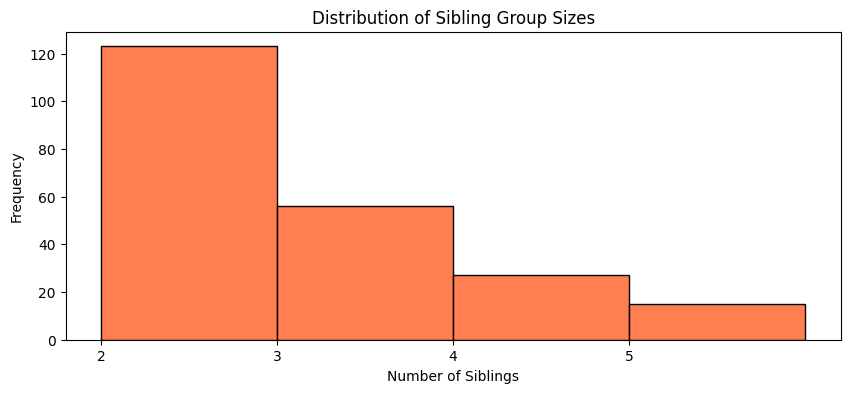

In [27]:
# --- FAMILY-SPECIFIC: Sibling Group Analysis ---
# Find all sibling groups (people who share a parent)

from collections import defaultdict

# Map each person to their parents
parents_of = defaultdict(set)
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in ['fatherOf', 'motherOf']:
        parents_of[t].add(h)
    elif r in ['sonOf', 'daughterOf']:
        parents_of[h].add(t)

# Group children by parent sets
parent_to_children = defaultdict(set)
for child, parents in parents_of.items():
    parent_key = tuple(sorted(parents))
    if parent_key:  # Has at least one parent
        parent_to_children[parent_key].add(child)

# Analyze sibling group sizes
sibling_groups = [children for children in parent_to_children.values() if len(children) > 1]
sibling_sizes = [len(g) for g in sibling_groups]

print(f"Number of sibling groups (2+ children): {len(sibling_groups)}")
if sibling_sizes:
    print(f"Average siblings per group: {sum(sibling_sizes)/len(sibling_sizes):.2f}")
    print(f"Largest sibling group: {max(sibling_sizes)} children")
    
    # Find the largest sibling group
    largest_group = max(sibling_groups, key=len)
    print(f"Members of largest sibling group: {largest_group}")
    
    plt.figure(figsize=(10, 4))
    plt.hist(sibling_sizes, bins=range(2, max(sibling_sizes)+2), edgecolor='black', color='coral')
    plt.xlabel("Number of Siblings")
    plt.ylabel("Frequency")
    plt.title("Distribution of Sibling Group Sizes")
    plt.xticks(range(2, max(sibling_sizes)+1))
    plt.show()

Largest family component: 27 people
Average path length: 1.470
  → On average, any two people are ~1.5 relationships apart
Diameter: 3
  → The most distant relatives are 3 steps apart
Radius: 2
Center nodes (most 'central' family members): ['isabella11', 'lisa5', 'natalie13', 'johanna22', 'lena18']...


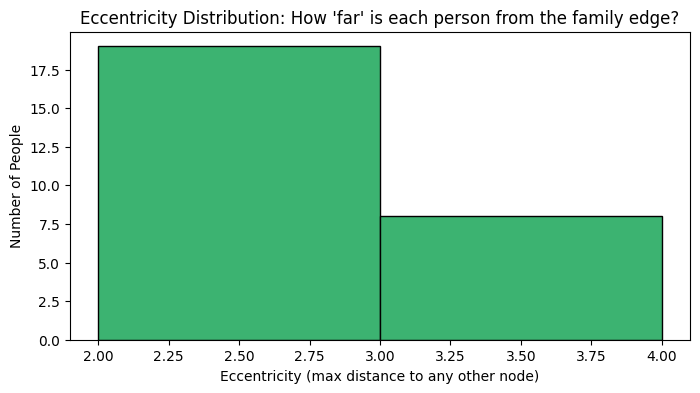

In [28]:
# --- PATH LENGTH ANALYSIS ---
# Compute on largest component (undirected for "family distance")

largest_cc = max(nx.weakly_connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).to_undirected()

print(f"Largest family component: {G_largest.number_of_nodes()} people")

# Average shortest path length
avg_path = nx.average_shortest_path_length(G_largest)
print(f"Average path length: {avg_path:.3f}")
print(f"  → On average, any two people are ~{avg_path:.1f} relationships apart")

# Diameter (we already computed this, but let's add context)
diameter = nx.diameter(G_largest)
print(f"Diameter: {diameter}")
print(f"  → The most distant relatives are {diameter} steps apart")

# Radius and Center
radius = nx.radius(G_largest)
center_nodes = nx.center(G_largest)
print(f"Radius: {radius}")
print(f"Center nodes (most 'central' family members): {center_nodes[:5]}...")

# Eccentricity distribution
eccentricity = nx.eccentricity(G_largest)
ecc_values = list(eccentricity.values())

plt.figure(figsize=(8, 4))
plt.hist(ecc_values, bins=range(min(ecc_values), max(ecc_values)+2), edgecolor='black', color='mediumseagreen')
plt.xlabel("Eccentricity (max distance to any other node)")
plt.ylabel("Number of People")
plt.title("Eccentricity Distribution: How 'far' is each person from the family edge?")
plt.show()

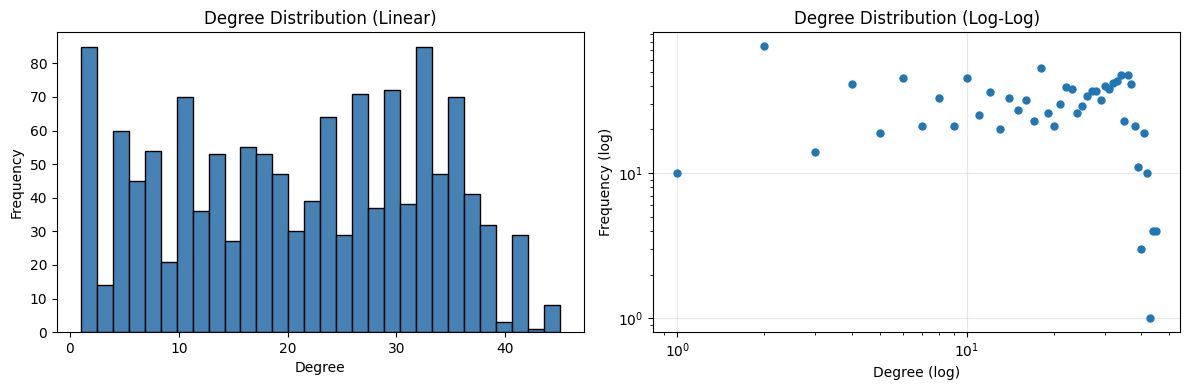

Degree Statistics:
  Min: 1
  Max: 45
  Mean: 21.00
  Median: 22


In [29]:
# --- DEGREE DISTRIBUTION: Is it Scale-Free? ---
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

plt.figure(figsize=(12, 4))

# Linear scale
plt.subplot(1, 2, 1)
plt.hist(degree_sequence, bins=30, edgecolor='black', color='steelblue')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution (Linear)")

# Log-log scale (power law would appear as straight line)
plt.subplot(1, 2, 2)
degree_counts = pd.Series(degree_sequence).value_counts().sort_index()
plt.loglog(degree_counts.index, degree_counts.values, 'o', markersize=5)
plt.xlabel("Degree (log)")
plt.ylabel("Frequency (log)")
plt.title("Degree Distribution (Log-Log)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Basic stats
print(f"Degree Statistics:")
print(f"  Min: {min(degree_sequence)}")
print(f"  Max: {max(degree_sequence)}")
print(f"  Mean: {sum(degree_sequence)/len(degree_sequence):.2f}")
print(f"  Median: {sorted(degree_sequence)[len(degree_sequence)//2]}")

In [4]:
# 1. Degree Centrality (Who has the most direct connections?)
degree_dict = dict(G.degree(G.nodes()))
sorted_degree = sorted(degree_dict.items(), key=lambda item: item[1], reverse=True)

print("Top 5 Most Connected People (Hubs):")
for node, degree in sorted_degree[:5]:
    print(f"{node}: {degree} connections")

# 2. Graph Density (How 'tight' is the family?)
density = nx.density(G)
print(f"\nGraph Density: {density:.6f}")
# Insight: Family trees are usually sparse (low density).

# 3. Diameter (Longest shortest path)
# Note: Diameter creates errors if the graph is disconnected.
# We calculate it on the largest component only.
largest_cc_nodes = max(nx.weakly_connected_components(G), key=len)
largest_subgraph = G.subgraph(largest_cc_nodes)

# Warning: This might be slow on 13k nodes. If it hangs, skip it.
try:
    # We treat it as undirected for 'family distance'
    diameter = nx.diameter(largest_subgraph.to_undirected())
    print(f"Diameter of the largest family cluster: {diameter}")
except Exception as e:
    print("Could not calculate diameter (graph might be too complex/disconnected)")

Top 5 Most Connected People (Hubs):
dominik1036: 45 connections
magdalena1044: 45 connections
oliver1045: 45 connections
lisa1035: 45 connections
oskar133: 44 connections

Graph Density: 0.007987
Diameter of the largest family cluster: 3


Visualizing the neighborhood of: dominik1036


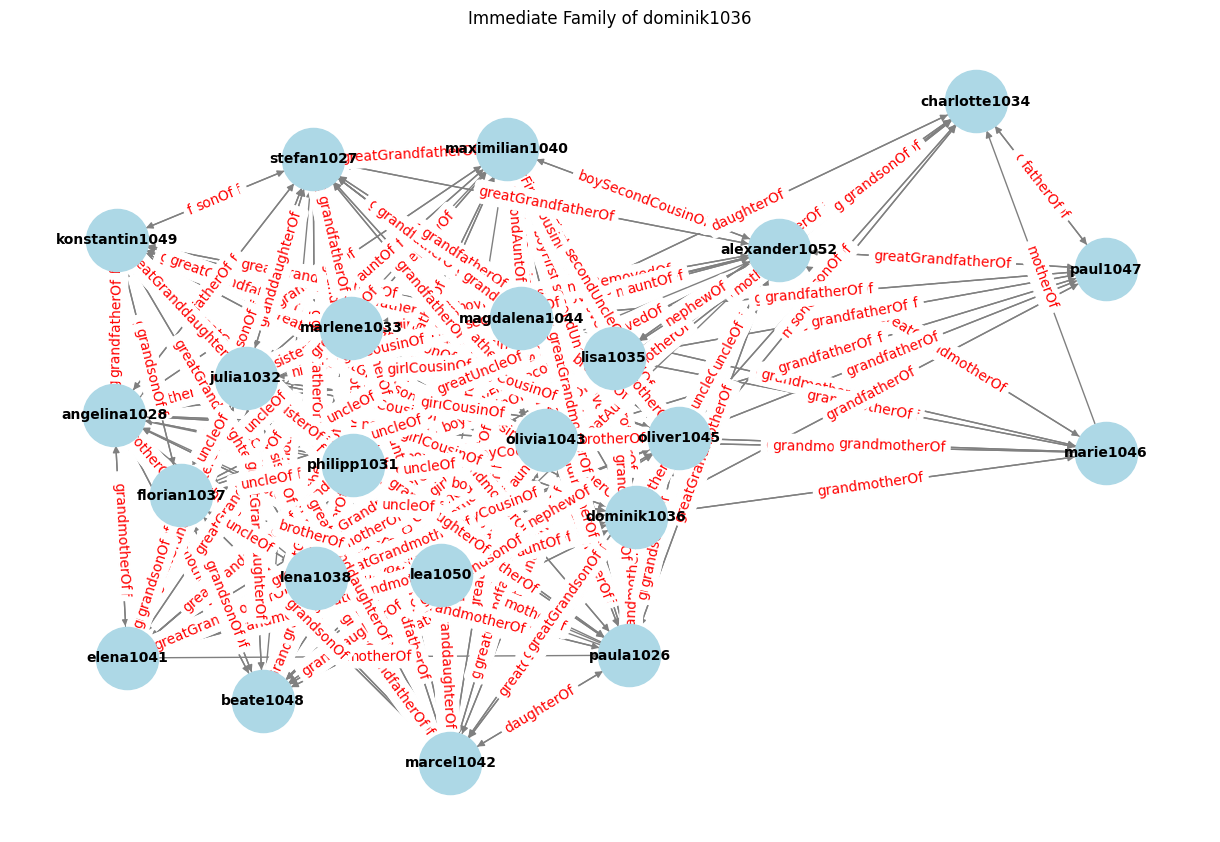

In [5]:
# Pick the most connected person from previous output (Dominik10136)
center_node = sorted_degree[0][0] 
print(f"Visualizing the neighborhood of: {center_node}")

# Create a subgraph of just this person and their direct neighbors (Radius=1)
# Radius=2 will show neighbors of neighbors (grandparents/cousins)
subgraph = nx.ego_graph(G, center_node, radius=1)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # consistent layout

# Draw nodes and edges
nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', 
        node_size=2000, font_size=10, font_weight='bold', edge_color='gray')

# Draw edge labels (relationships)
edge_labels = nx.get_edge_attributes(subgraph, 'relation')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red')

plt.title(f"Immediate Family of {center_node}")
plt.show()

Found 495 ancestral roots (founding members).

Population by Generation:
0    495
1    215
2    192
3    206
4    146
5     55
6      7
Name: count, dtype: int64


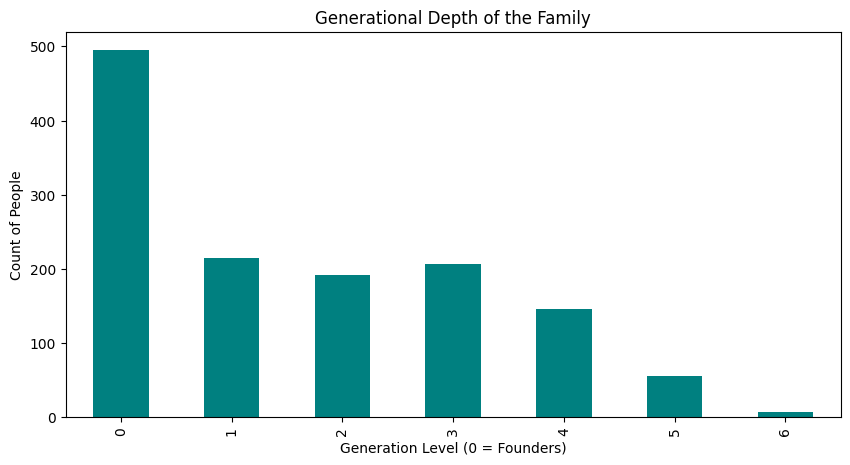

In [6]:
# --- ANALYSIS 1: Generation Detection ---
# Goal: Assign a 'Generation Level' to nodes based on parent/child links.

# 1. Filter for "Vertical" edges only
# We ignore "sisterOf" or "cousinOf" because they stay within the same generation.
# We only care about edges that move TIME forward or backward.
# Let's standardize: Parent -> Child edges.
vertical_relations = ['fatherOf', 'motherOf']
inverse_vertical = ['sonOf', 'daughterOf']

# Create a "Time Graph" (Parents pointing to Children)
time_graph = nx.DiGraph()
for u, v, data in G.edges(data=True):
    r = data['relation']
    if r in vertical_relations:
        time_graph.add_edge(u, v)  # Parent -> Child
    elif r in inverse_vertical:
        time_graph.add_edge(v, u)  # Child -> Parent (flip to Parent -> Child)

# 2. Find the "Ancestors" (Roots)
# These are people with 0 incoming edges in our Time Graph (No parents listed)
ancestors = [n for n in time_graph.nodes() if time_graph.in_degree(n) == 0]
print(f"Found {len(ancestors)} ancestral roots (founding members).")

# 3. Calculate Generations (Longest Path from an Ancestor)
# We use a topological sort approach or simple BFS/DFS layer count.
generations = {}
# Initialize ancestors as Generation 0
for root in ancestors:
    generations[root] = 0

# Propagate down
# Note: This is a simplification. A robust way is 'longest path' in a DAG.
for node in nx.topological_sort(time_graph):
    if node not in generations:
        parents = list(time_graph.predecessors(node))
        if parents:
            # You are 1 generation below your 'youngest' parent recorded
            parent_gens = [generations.get(p, 0) for p in parents]
            generations[node] = max(parent_gens) + 1
        else:
            generations[node] = 0

# 4. Visualization: The "Demographic Pyramid"
gen_counts = pd.Series(generations.values()).value_counts().sort_index()
print("\nPopulation by Generation:")
print(gen_counts)

plt.figure(figsize=(10, 5))
gen_counts.plot(kind='bar', color='teal')
plt.title("Generational Depth of the Family")
plt.xlabel("Generation Level (0 = Founders)")
plt.ylabel("Count of People")
plt.show()

In [30]:
# --- Investigating: Why 495 ancestral roots? ---
# Let's understand who these "ancestors" are

print(f"Total nodes in time_graph: {time_graph.number_of_nodes()}")
print(f"Total nodes in full graph: {G.number_of_nodes()}")
print(f"Nodes NOT in time_graph: {G.number_of_nodes() - time_graph.number_of_nodes()}")

# Nodes with no parents in the data
ancestors = [n for n in time_graph.nodes() if time_graph.in_degree(n) == 0]

# What relationships DO these ancestors have?
ancestor_relations = df[df['head'].isin(ancestors)]['relation'].value_counts()
print(f"\nRelationships held by 'ancestors' (nodes with no parents recorded):")
print(ancestor_relations.head(15))

# Check: Are some "ancestors" actually middle-generation people with missing parent data?
# If someone is an "ancestor" but has grandchildren, their parents are just missing
ancestor_with_grandkids = []
for anc in ancestors:
    rels = df[df['head'] == anc]['relation'].tolist()
    if 'grandfatherOf' in rels or 'grandmotherOf' in rels:
        # They have grandkids, so they should have parents too (just missing)
        ancestor_with_grandkids.append(anc)

print(f"\n'Ancestors' who have grandchildren (so probably have missing parents): {len(ancestor_with_grandkids)}")
print(f"True founding ancestors (no grandchildren): {len(ancestors) - len(ancestor_with_grandkids)}")

Total nodes in time_graph: 1316
Total nodes in full graph: 1316
Nodes NOT in time_graph: 0

Relationships held by 'ancestors' (nodes with no parents recorded):
relation
grandmotherOf         520
grandfatherOf         489
greatGrandmotherOf    469
greatGrandfatherOf    457
motherOf              383
fatherOf              363
Name: count, dtype: int64

'Ancestors' who have grandchildren (so probably have missing parents): 381
True founding ancestors (no grandchildren): 114


In [7]:
# --- ANALYSIS 2: Gender Inference & Consistency ---
# Goal: Infer gender from relationship labels and find data errors.

male_relations = {'fatherOf', 'brotherOf', 'sonOf', 'uncleOf', 'nephewOf', 'grandfatherOf', 'grandsonOf'}
female_relations = {'motherOf', 'sisterOf', 'daughterOf', 'auntOf', 'nieceOf', 'grandmotherOf', 'granddaughterOf'}

inferred_gender = {}
conflicts = []

for u, v, data in G.edges(data=True):
    r = data['relation']
    
    # Check Source (u)
    if r in male_relations:
        if inferred_gender.get(u) == 'F': conflicts.append((u, 'Expected M, was F'))
        inferred_gender[u] = 'M'
    elif r in female_relations:
        if inferred_gender.get(u) == 'M': conflicts.append((u, 'Expected F, was M'))
        inferred_gender[u] = 'F'

print(f"Inferred gender for {len(inferred_gender)} nodes.")
print(f"Male count: {list(inferred_gender.values()).count('M')}")
print(f"Female count: {list(inferred_gender.values()).count('F')}")

if conflicts:
    print(f"\nCRITICAL DATA ERROR: Found {len(conflicts)} gender contradictions!")
    print(conflicts[:5])
else:
    print("\nData Quality Check Passed: No gender contradictions found.")

Inferred gender for 1316 nodes.
Male count: 646
Female count: 670

Data Quality Check Passed: No gender contradictions found.



Top 'Gatekeepers' (Crucial bridges with relatively few direct connections):
             degree  betweenness  gatekeeper_score
node                                              
luisa852   0.015970     0.000117          0.006879
lea862     0.020532     0.000147          0.006826
marko1315  0.012167     0.000082          0.006203
anna438    0.009886     0.000067          0.006137
sofia285   0.018251     0.000118          0.006134


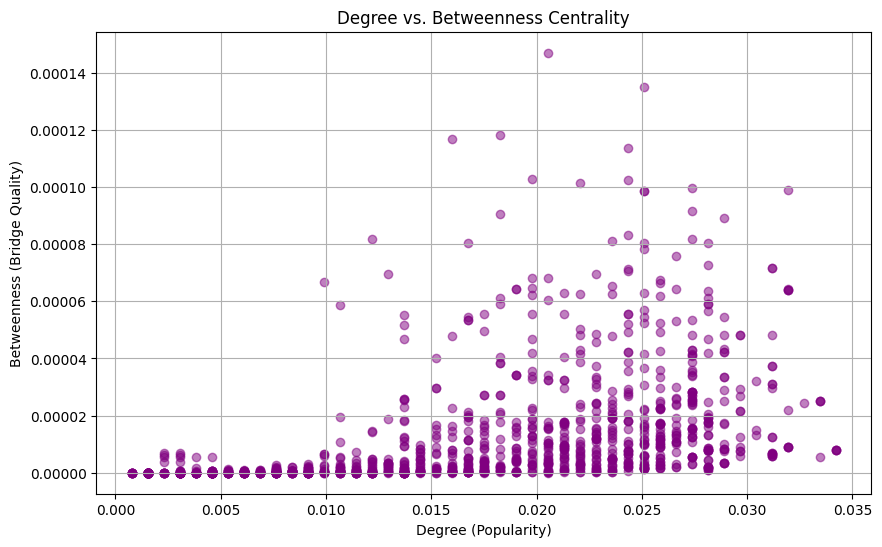

In [8]:
# --- ANALYSIS 3: The "Gatekeepers" vs "The Popular" ---

# Calculate Betweenness (I found out it is slow on 13k nodes, so let's estimate with k=500 samples)
betweenness = nx.betweenness_centrality(G, k=500, seed=42)
degree = nx.degree_centrality(G)

# Create a DataFrame to compare
centrality_df = pd.DataFrame({
    'node': list(G.nodes()),
    'degree': [degree[n] for n in G.nodes()],
    'betweenness': [betweenness.get(n, 0) for n in G.nodes()]
}).set_index('node')

# Find the "Gatekeepers": Low Degree but High Betweenness
# These people connect two massive branches but have few kids themselves.
centrality_df['gatekeeper_score'] = centrality_df['betweenness'] / (centrality_df['degree'] + 0.001)
top_gatekeepers = centrality_df.sort_values('gatekeeper_score', ascending=False).head(5)

print("\nTop 'Gatekeepers' (Crucial bridges with relatively few direct connections):")
print(top_gatekeepers)

# Plotting the "Power Structure"
plt.figure(figsize=(10, 6))
plt.scatter(centrality_df['degree'], centrality_df['betweenness'], alpha=0.5, color='purple')
plt.title("Degree vs. Betweenness Centrality")
plt.xlabel("Degree (Popularity)")
plt.ylabel("Betweenness (Bridge Quality)")
plt.grid(True)
plt.show()

In [9]:
# --- Cycle Analysis (Only on Parent-Child "Time Graph") ---
# Cycles in the FULL graph are expected (siblings are symmetric: A sisterOf B, B sisterOf A)
# We only care about cycles in the TIME GRAPH (would mean someone is their own ancestor)

# Using time_graph from above cells
try:
    cycles = list(nx.find_cycle(time_graph, orientation='original'))
    print(f"TEMPORAL PARADOX: Found a cycle in parent-child relationships! {cycles[:3]}")
except nx.NetworkXNoCycle:
    print("Temporal Logic Verified: No one is their own ancestor.")

# NEW: Let's understand the symmetric relationships properly
symmetric_relations = ['sisterOf', 'brotherOf', 'boyCousinOf', 'girlCousinOf']
symmetric_edges = df[df['relation'].isin(symmetric_relations)]
print(f"\nSymmetric relationship edges: {len(symmetric_edges)}")
print("These create 'cycles' in the full graph, which is expected behavior.")

✅ Temporal Logic Verified: No one is their own ancestor.

Symmetric relationship edges: 2042
These create 'cycles' in the full graph, which is expected behavior.


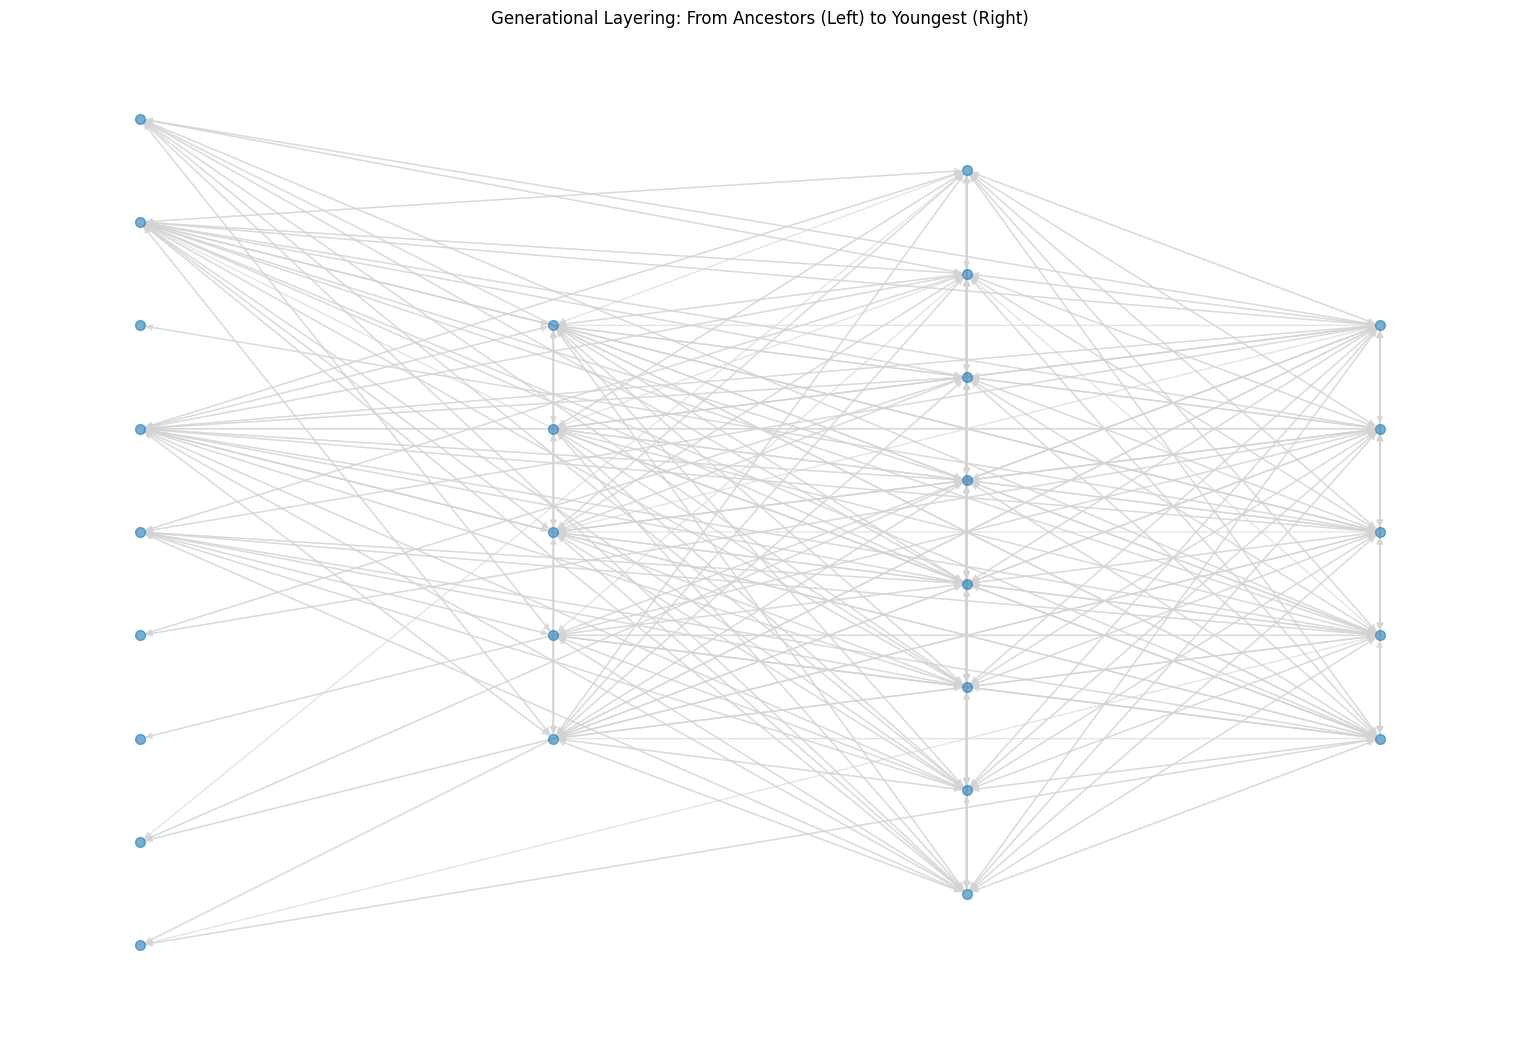

In [10]:
# Select the largest component to visualize the most complex family
largest_cc = max(nx.weakly_connected_components(G), key=len)
S = G.subgraph(largest_cc).copy()

# Use the generation dict from your Deep Dive 1
# Assign 'layer' attribute for the Multipartite Layout
for node in S.nodes():
    S.nodes[node]['layer'] = generations.get(node, 0)

# Use multipartite_layout to arrange nodes by generation
pos = nx.multipartite_layout(S, subset_key="layer")

plt.figure(figsize=(15, 10))
nx.draw(S, pos, node_size=50, edge_color='lightgray', alpha=0.6, with_labels=False)
plt.title("Generational Layering: From Ancestors (Left) to Youngest (Right)")
plt.show()

In [11]:
from itertools import combinations

# Analyze triads: Find cases where A is related to B and B to C
triads = []
for n in G.nodes():
    neighbors = list(G.successors(n))
    if len(neighbors) < 2: continue
    for n1, n2 in combinations(neighbors, 2):
        if G.has_edge(n1, n2):
            # We found a triangle!
            r1 = G[n][n1]['relation']
            r2 = G[n1][n2]['relation']
            r3 = G[n][n2]['relation']
            triads.append((r1, r2, r3))

triad_df = pd.DataFrame(triads, columns=['Rel_AB', 'Rel_BC', 'Rel_AC'])
top_motifs = triad_df.value_counts().head(10)

print("Top Relationship Triads (The 'DNA' of the Family):")
print(top_motifs)

Top Relationship Triads (The 'DNA' of the Family):
Rel_AB           Rel_BC                Rel_AC            
sisterOf         granddaughterOf       granddaughterOf       772
                 grandsonOf            granddaughterOf       722
brotherOf        granddaughterOf       grandsonOf            722
                 grandsonOf            grandsonOf            624
granddaughterOf  greatGrandfatherOf    auntOf                562
                 greatGrandmotherOf    auntOf                562
grandmotherOf    auntOf                greatGrandmotherOf    562
grandfatherOf    auntOf                greatGrandfatherOf    562
uncleOf          greatGranddaughterOf  grandsonOf            544
greatGrandsonOf  grandfatherOf         nephewOf              541
Name: count, dtype: int64


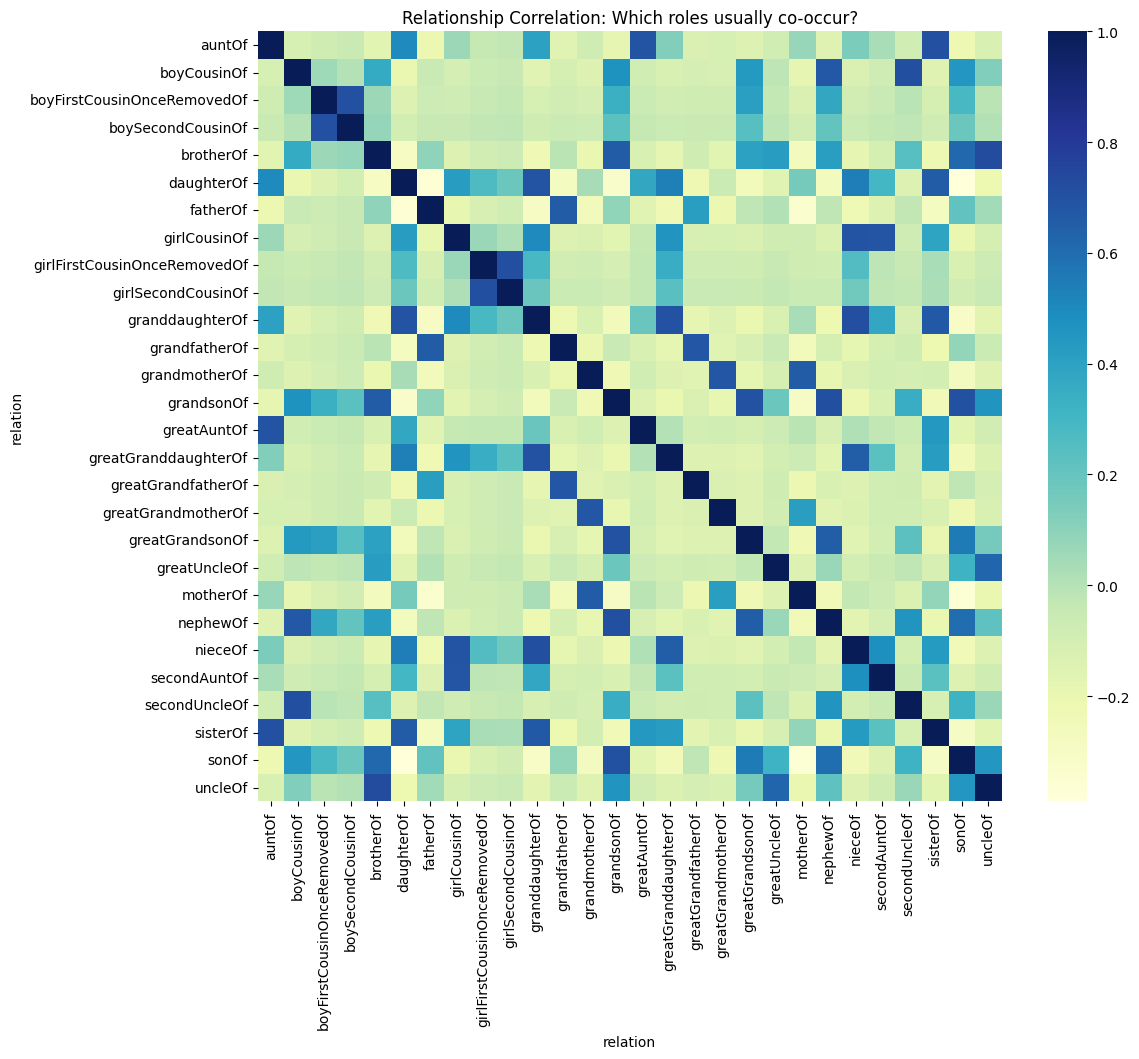

In [12]:
import seaborn as sns

# Create a pivot table of how often Relationship X connects to nodes that also have Relationship Y
# This shows 'Relationship Overlap'
adj_matrix = nx.to_pandas_adjacency(G.to_undirected())
# For a more specific KG view, analyze the frequency of Relation pairs for shared nodes
rel_counts = df.groupby(['head', 'relation']).size().unstack(fill_value=0)
rel_corr = rel_counts.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(rel_corr, annot=False, cmap='YlGnBu')
plt.title("Relationship Correlation: Which roles usually co-occur?")
plt.show()

In [13]:
import networkx.algorithms.community as nx_comm
import matplotlib.cm as cm

# 1. Prepare the Data
# We focus on the Largest Component (The big "Clan")
largest_cc = max(nx.weakly_connected_components(G), key=len)
S = G.subgraph(largest_cc).copy()

# Louvain works on Undirected graphs (Relationships imply connection regardless of direction)
U = S.to_undirected()

print(f"Algorithm 1: Running Louvain on the largest clan ({S.number_of_nodes()} people)...")

# 2. Execute Louvain Algorithm
# seed=42 ensures reproducibility (Crucial for your report!)
louvain_communities = nx_comm.louvain_communities(U, seed=42)

# 3. Calculate the Score
# This is the number you need for the "Objectively assess quality" part of the prompt 
modularity_score = nx_comm.modularity(U, louvain_communities)

print(f"✅ Detection Complete!")
print(f"Found {len(louvain_communities)} distinct communities (sub-families).")
print(f"Modularity Score: {modularity_score:.4f} ( > 0.4 is usually strong structure)")

# 4. Qualitative Logic Check (The "Vibe Check")
# Let's peek at the first 3 communities to see if they look like families
print("\n--- Family Inspection ---")
for i, comm in enumerate(louvain_communities[:3]):
    print(f"Community {i+1} has {len(comm)} members: {list(comm)[:5]}...")
    
    # Check what binds them together
    # Are they mostly siblings? Parents?
    sub = U.subgraph(comm)
    density = nx.density(sub)
    print(f"  -> Internal Density: {density:.2f}") 
    # High density (near 1.0) = Nuclear Family (Everyone connected to everyone)
    # Low density = Extended cousins

Algorithm 1: Running Louvain on the largest clan (27 people)...
✅ Detection Complete!
Found 2 distinct communities (sub-families).
Modularity Score: 0.0726 ( > 0.4 is usually strong structure)

--- Family Inspection ---
Community 1 has 12 members: ['isabella11', 'selina10', 'oliver3', 'adam9', 'lisa5']...
  -> Internal Density: 0.86
Community 2 has 15 members: ['vincent21', 'mia17', 'emily15', 'natalie13', 'valentina25']...
  -> Internal Density: 0.58


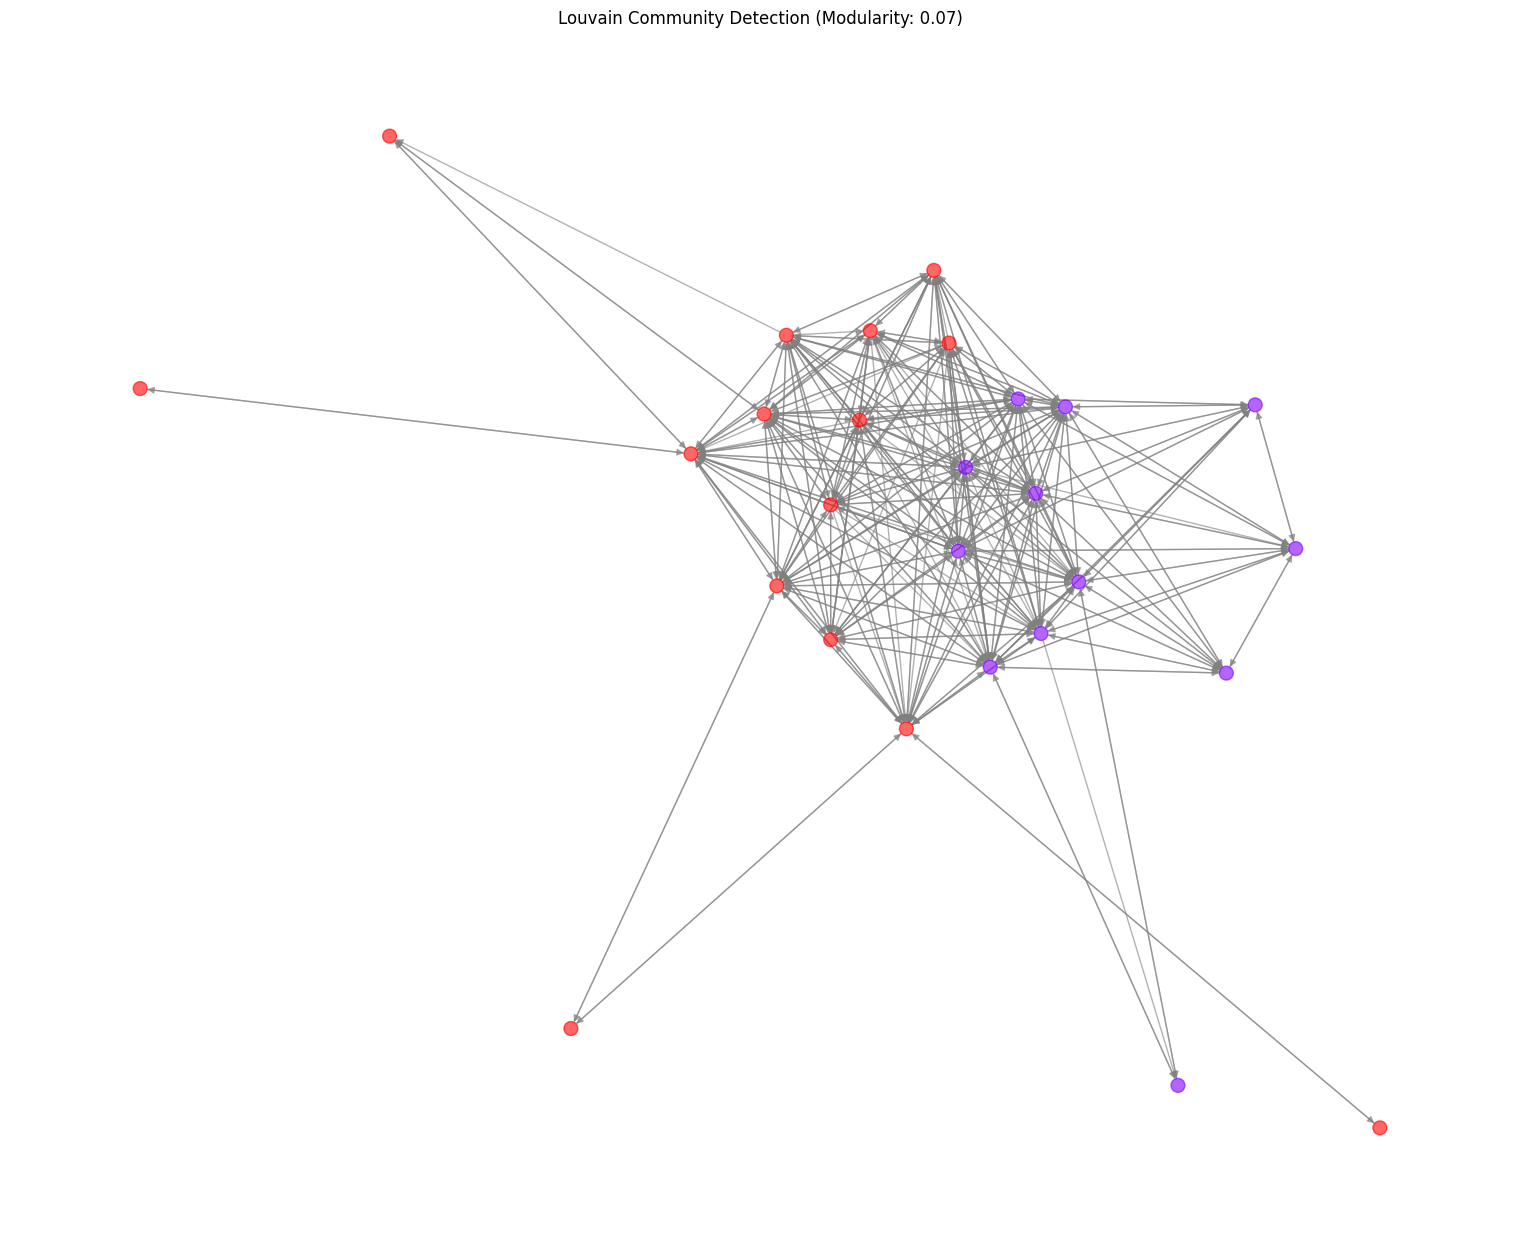

In [14]:
# 5. Visualizing the Clusters
pos = nx.spring_layout(S, seed=42, k=0.15)  # k regulates spacing

# Generate a color map
# Assign a unique color to each community
node_color = []
# Create a mapping: Node -> Community ID
community_map = {}
for i, comm in enumerate(louvain_communities):
    for node in comm:
        community_map[node] = i

for node in S.nodes():
    node_color.append(community_map[node])

plt.figure(figsize=(15, 12))
nx.draw(S, pos, node_size=100, cmap=cm.rainbow, node_color=node_color, 
        edge_color='gray', alpha=0.6, with_labels=False)
plt.title(f"Louvain Community Detection (Modularity: {modularity_score:.2f})")
plt.show()

In [15]:
# --- TASK 2 EXTENSION: Global vs Local Structure ---

# 1. Run Louvain on the WHOLE graph (1300+ nodes)
# Note: Louvain is fast enough to handle 13k edges easily.
U_global = G.to_undirected()
global_communities = nx_comm.louvain_communities(U_global, seed=42)
global_modularity = nx_comm.modularity(U_global, global_communities)

print(f"Global Modularity (Whole Graph): {global_modularity:.4f}")
print(f"Number of Global Communities found: {len(global_communities)}")

# 2. Compare with your Local Run (The 27-person clan)
# (You already have this from the previous cell, just restating for the report logic)
print(f"Local Modularity (Largest Clan): {modularity_score:.4f}")

# 3. Insight Generator
if global_modularity > 0.8 and modularity_score < 0.2:
    print("\n💡 MAJOR INSIGHT CONFIRMED: The graph is composed of highly distinct, isolated clans.")
    print("The algorithm can easily separate the families (Global), but cannot split the families internally (Local).")
    print("This implies the dataset represents distinct lineages rather than a single interconnected society.")

Global Modularity (Whole Graph): 0.9794
Number of Global Communities found: 50
Local Modularity (Largest Clan): 0.0726

💡 MAJOR INSIGHT CONFIRMED: The graph is composed of highly distinct, isolated clans.
The algorithm can easily separate the families (Global), but cannot split the families internally (Local).
This implies the dataset represents distinct lineages rather than a single interconnected society.


In [16]:
from networkx.algorithms.community.centrality import girvan_newman

# We run this on the subgraph 'S' (The 27-person clan)
# Girvan-Newman is slow, so running it on the small subgraph is perfect.
print("Algorithm 2: Running Girvan-Newman on the largest clan...")

# GN returns an iterator of communities at each level of the split
comp = girvan_newman(S.to_undirected())

# Get the first split (k=2 communities)
gn_communities = next(comp)

print(f"Girvan-Newman split the clan into {len(gn_communities)} groups.")
print(f"Group sizes: {[len(c) for c in gn_communities]}")

# Calculate Modularity for GN
gn_modularity = nx_comm.modularity(S.to_undirected(), gn_communities)
print(f"Girvan-Newman Modularity: {gn_modularity:.4f}")

# Compare with Louvain
print(f"\nComparison:")
print(f"Louvain Modularity: {modularity_score:.4f}")
print(f"Girvan-Newman Modularity: {gn_modularity:.4f}")

Algorithm 2: Running Girvan-Newman on the largest clan...
Girvan-Newman split the clan into 2 groups.
Group sizes: [26, 1]
Girvan-Newman Modularity: -0.0000

Comparison:
Louvain Modularity: 0.0726
Girvan-Newman Modularity: -0.0000


In [17]:
# --- TASK 2 FINAL: The "Relatedness" Metric (SimRank) ---
import itertools

# 1. Setup: We use the 27-person clan (subgraph S)
# SimRank is O(n^4), so we MUST use the subgraph, not the whole graph.
# We convert to undirected to capture "sibling" links (which are visually undirected)
U_clan = S.to_undirected()

print(f"Calculating SimRank for the {U_clan.number_of_nodes()} members of the largest clan...")
print("This finds who is 'structurally' similar (e.g., Cousins vs Siblings)...")

# 2. Run SimRank
# beta=0.8 means "My parents' similarity contributes 80% to my similarity"
sim = nx.simrank_similarity(U_clan, importance_factor=0.8)

# 3. Validation: Let's test "Who is most related to whom?"
# We'll pick the most connected person and see who SimRank thinks is their "closest relative"
target_person = sorted(U_clan.degree, key=lambda x: x[1], reverse=True)[0][0]
print(f"\n--- Relationship Radar for {target_person} ---")

# Get all similarity scores for this person
scores = sim[target_person]

# Sort by score (highest = most related)
sorted_relatives = sorted(scores.items(), key=lambda x: x[1], reverse=True)

# Print Top 5 (excluding self)
print(f"{'Rank':<5} {'Relative':<15} {'Score':<10} {'Inferred Relation'}")
print("-" * 50)
# ... inside the loop ...
for i, (relative, score) in enumerate(sorted_relatives[1:6]):
    if U_clan.has_edge(target_person, relative):
        edge_data = U_clan.get_edge_data(target_person, relative)
        # FIX: Access the dictionary directly
        rel_label = edge_data.get('relation', 'Unknown') 
    else:
        rel_label = "Indirect (e.g. Cousin)"
        
    print(f"#{i+1:<4} {relative:<15} {score:.4f}     {rel_label}")

# 4. Insight Generation for Report
print("\nInterpretations:")
print("1. If Score > 0.5: Likely Siblings or Parent/Child.")
print("2. If Score ~ 0.2-0.4: Likely Cousins (Structurally similar but distant).")
print("3. Comparison: Shortest Path would just say 'Distance 1' for all direct edges.")
print("   SimRank differentiates: A 'Sister' might score higher than an 'Aunt' even if both are 1 hop.")

Calculating SimRank for the 27 members of the largest clan...
This finds who is 'structurally' similar (e.g., Cousins vs Siblings)...

--- Relationship Radar for lisa5 ---
Rank  Relative        Score      Inferred Relation
--------------------------------------------------
#1    vincent21       0.1527     Indirect (e.g. Cousin)
#2    emily15         0.1524     Indirect (e.g. Cousin)
#3    nico4           0.1520     brotherOf
#4    elias6          0.1520     brotherOf
#5    valentina25     0.1519     Indirect (e.g. Cousin)

Interpretations:
1. If Score > 0.5: Likely Siblings or Parent/Child.
2. If Score ~ 0.2-0.4: Likely Cousins (Structurally similar but distant).
3. Comparison: Shortest Path would just say 'Distance 1' for all direct edges.
   SimRank differentiates: A 'Sister' might score higher than an 'Aunt' even if both are 1 hop.


In [18]:
# --- CORRECTED TASK 2: "Skeleton" SimRank ---

# 1. Filter the Graph (The "Skeleton" approach)
# We only keep biological parent/child links.
# This forces the algorithm to distinguish between sharing a Parent (Close)
# vs sharing a Grandparent (Far).
allowed_relations = ['fatherOf', 'motherOf', 'sonOf', 'daughterOf']

# Create a filtered subgraph of the clan
edges_to_keep = []
for u, v, data in S.edges(data=True):
    if data['relation'] in allowed_relations:
        edges_to_keep.append((u, v))

# Create the Skeleton Graph
skeleton_graph = G.edge_subgraph(edges_to_keep).subgraph(S.nodes()).copy().to_undirected()

print(f"Skeleton Graph: {skeleton_graph.number_of_nodes()} nodes, {skeleton_graph.number_of_edges()} edges.")
print("(Removed 'cousinOf', 'grandfatherOf', etc. to fix the hierarchy issue)")

# 2. Run SimRank on the Skeleton
print("\nRecalculating SimRank on Skeleton Graph...")
sim_skeleton = nx.simrank_similarity(skeleton_graph, importance_factor=0.8)

# 3. Validation: Check the Rankings again
target_person = 'nico4' # Keeping the same target for comparison
print(f"\n--- Corrected Relationship Radar for {target_person} ---")

scores = sim_skeleton[target_person]
sorted_relatives = sorted(scores.items(), key=lambda x: x[1], reverse=True)

print(f"{'Rank':<5} {'Relative':<15} {'Score':<10} {'Real Relation'}")
print("-" * 50)

for i, (relative, score) in enumerate(sorted_relatives[1:6]):
    # Get the REAL relation from the ORIGINAL graph (S), not the skeleton
    if S.has_edge(target_person, relative):
        rel_label = S.get_edge_data(target_person, relative)['relation']
    else:
        rel_label = "Indirect"
        
    print(f"#{i+1:<4} {relative:<15} {score:.4f}     {rel_label}")

Skeleton Graph: 27 nodes, 36 edges.
(Removed 'cousinOf', 'grandfatherOf', etc. to fix the hierarchy issue)

Recalculating SimRank on Skeleton Graph...

--- Corrected Relationship Radar for nico4 ---
Rank  Relative        Score      Real Relation
--------------------------------------------------
#1    lisa5           0.5690     brotherOf
#2    elias6          0.5690     brotherOf
#3    dominik2        0.2689     grandsonOf
#4    katharina1      0.2339     grandsonOf
#5    natalie13       0.1023     Indirect


Spectral Clustering Split:
Cluster A (4): ['lena18', 'mia17', 'emily15', 'leon16']...
Cluster B (23): ['isabella11', 'lisa5', 'natalie13', 'johanna22', 'fabian26']...


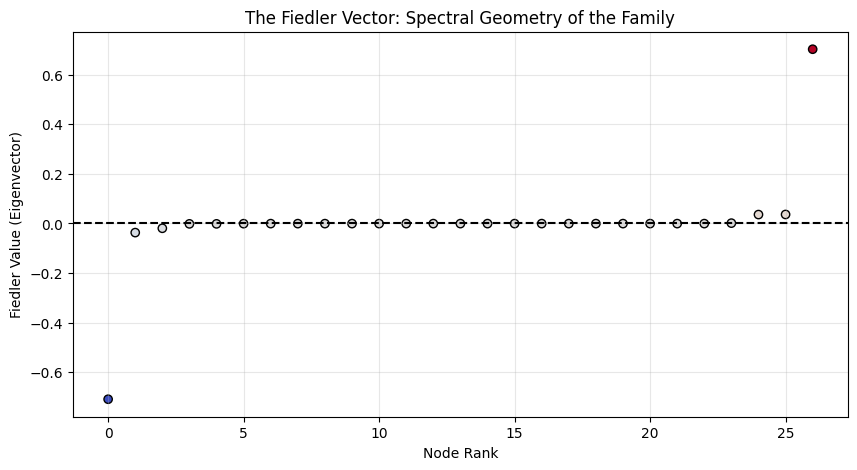


Math Check:
Cut Size: 34 edges crossing the split.
Conductance: 0.8095 (Lower is a better, cleaner cut)


In [19]:
import numpy as np
import scipy.linalg as la

# --- TASK 2: SPECTRAL CLUSTERING (The "Math" Approach) ---

# 1. Setup: Use the Largest Clan (Subgraph S)
# Convert to Undirected and ensure nodes are ordered
U = S.to_undirected()
nodes_list = list(U.nodes())
n = len(nodes_list)

# 2. Get the Laplacian Matrix
# L = Degree_Matrix - Adjacency_Matrix
# This matrix captures the "flow" of the graph
L = nx.laplacian_matrix(U).toarray()

# 3. Calculate Eigenvalues and Eigenvectors
# We look for the "Fiedler Vector" (The eigenvector of the 2nd smallest eigenvalue)
eigenvalues, eigenvectors = la.eigh(L)

# The 2nd smallest eigenvalue's vector tells us how to cut the graph
fiedler_vector = eigenvectors[:, 1]

# 4. Clustering Logic
# Nodes with positive values go to Cluster A, negative to Cluster B
spectral_cluster_A = []
spectral_cluster_B = []

for i, score in enumerate(fiedler_vector):
    if score > 0:
        spectral_cluster_A.append(nodes_list[i])
    else:
        spectral_cluster_B.append(nodes_list[i])

print(f"Spectral Clustering Split:")
print(f"Cluster A ({len(spectral_cluster_A)}): {spectral_cluster_A[:5]}...")
print(f"Cluster B ({len(spectral_cluster_B)}): {spectral_cluster_B[:5]}...")

# 5. Visualization: The "Fiedler Ordering"
# If we sort the nodes by their Fiedler Score, do we see distinct steps (Families) 
# or a smooth slope (Generations)?
sorted_indices = np.argsort(fiedler_vector)
sorted_scores = fiedler_vector[sorted_indices]

plt.figure(figsize=(10, 5))
plt.scatter(range(n), sorted_scores, c=sorted_scores, cmap='coolwarm', edgecolor='black')
plt.axhline(0, color='black', linestyle='--')
plt.title("The Fiedler Vector: Spectral Geometry of the Family")
plt.xlabel("Node Rank")
plt.ylabel("Fiedler Value (Eigenvector)")
plt.grid(True, alpha=0.3)
plt.show()

# 6. Insight Calculation
# Calculate Cut Conductance (How "expensive" is this cut?)
cut_edges = nx.cut_size(U, spectral_cluster_A, spectral_cluster_B)
conductance = nx.conductance(U, spectral_cluster_A, spectral_cluster_B)

print(f"\nMath Check:")
print(f"Cut Size: {cut_edges} edges crossing the split.")
print(f"Conductance: {conductance:.4f} (Lower is a better, cleaner cut)")

In [20]:
# --- TASK 2 EXTENSION: LEIDEN ALGORITHM ---
!pip install leidenalg igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 48.9 MB/s eta 0:00:0000:01


In [21]:

import leidenalg as la
import igraph as ig

print("Algorithm 3: Running Leiden (The Modern Standard)...")

# 1. Convert NetworkX Graph to iGraph
# Leiden is optimized in C++ and uses the 'igraph' library structure
# We pass our subgraph 'S' (The 27-person clan)
# We need to map node names to integer indices for igraph
node_map = {node: i for i, node in enumerate(S.nodes())}
edges_indices = [(node_map[u], node_map[v]) for u, v in S.edges()]

G_ig = ig.Graph(len(S), edges_indices)

# 2. Run Leiden
# We use 'ModularityVertexPartition' to be comparable with Louvain
# n_iterations=-1 means run until convergence
leiden_part = la.find_partition(G_ig, la.ModularityVertexPartition, n_iterations=-1, seed=42)

# 3. Extract Results
leiden_communities = []
for i in range(len(leiden_part)):
    members_indices = leiden_part[i]
    # Map back to string names
    # Create a reverse map or list lookup
    nodes_list = list(S.nodes())
    members_names = [nodes_list[idx] for idx in members_indices]
    leiden_communities.append(members_names)

# 4. Calculate Scores
leiden_modularity = leiden_part.quality()

print(f"✅ Leiden Detection Complete!")
print(f"Found {len(leiden_communities)} communities.")
print(f"Leiden Modularity: {leiden_modularity:.4f}")

# 5. Compare with Louvain (Recall: 0.0726)
# If Leiden is significantly higher, it found structure Louvain missed.
print(f"\nComparison:")
print(f"Louvain: 0.0726 (Coarse)")
print(f"Leiden:  {leiden_modularity:.4f} (Refined)")

if len(leiden_communities) > 1:
    print("\nLeiden successfully split the clan! Here is Community 1:")
    print(leiden_communities[0])
else:
    print("\nLeiden CONFIRMED the Louvain result: The clan is mathematically indivisible.")

Algorithm 3: Running Leiden (The Modern Standard)...
✅ Leiden Detection Complete!
Found 3 communities.
Leiden Modularity: 0.0765

Comparison:
Louvain: 0.0726 (Coarse)
Leiden:  0.0765 (Refined)

Leiden successfully split the clan! Here is Community 1:
['natalie13', 'johanna22', 'fabian26', 'olivia0', 'paula12', 'moritz8', 'valentina25', 'emma7', 'luis14', 'leon16', 'jonas23', 'vincent21', 'katharina1']
